In [1]:
!pip install plotly

In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import HashingTF, Tokenizer,VectorAssembler,FeatureHasher
from pyspark.sql import SparkSession
import pandas as pd

from pyspark.ml.evaluation import RegressionEvaluator


import os

In [3]:
spark = (SparkSession.builder
    .master("local")
    .appName("SQLite JDBC")
    .config(
        "spark.jars",
        "/Users/derib/data_architecture/sqlite-jdbc-3.34.0.jar".format(os.getcwd()))
    .config(
        "spark.driver.extraClassPath",
        "/Users/derib/data_architecture/sqlite-jdbc-3.34.0.jar".format(os.getcwd()))
    .getOrCreate())
spark

25/04/11 14:47:31 WARN Utils: Your hostname, MacBook-Pro-de-de.local resolves to a loopback address: 127.0.0.1; using 192.168.1.17 instead (on interface en0)
25/04/11 14:47:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/04/11 14:47:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
df_country = spark.read.jdbc(url='jdbc:sqlite:/Users/derib/data_architecture/tp2/education_career_success.db',table="Country")
df_uni = spark.read.jdbc(url='jdbc:sqlite:/Users/derib/data_architecture/tp2/education_career_success.db',table="University")
df_student_achievement = spark.read.jdbc(url='jdbc:sqlite:/Users/derib/data_architecture/tp2/education_career_success.db',table="StudentAchievementUni")
df_uni = spark.read.jdbc(url='jdbc:sqlite:/Users/derib/data_architecture/tp2/education_career_success.db',table="University")
df_student_job = spark.read.jdbc(url='jdbc:sqlite:/Users/derib/data_architecture/tp2/education_career_success.db',table="StudentJobs")
df_student = spark.read.jdbc(url='jdbc:sqlite:/Users/derib/data_architecture/tp2/education_career_success.db',table="Student")

In [5]:
df_student_achievement.columns

['achievementId',
 'studentId',
 'universityId',
 'universityGPA',
 'fieldOfStudyId']

In [6]:
df_student_achievement = df_student_achievement.dropna()
df_student_job = df_student_job.dropna()
df_university = df_uni.dropna()

In [7]:
df_student.columns

['studentId', 'gender', 'age']

In [8]:
df_university.columns

['universityId', 'universityRanking', 'universityName', 'countryId']

In [9]:
df_student_job.columns

['studentIdJob',
 'startingSalary',
 'careerSatisfaction',
 'currentJobLevel',
 'studentId']

In [10]:
df_all = df_student_achievement.join(df_student_job, on="StudentId", how="inner")



In [11]:
df_all.show(5)

+---------+-------------+------------+-------------+--------------+------------+--------------+------------------+---------------+
|studentId|achievementId|universityId|universityGPA|fieldOfStudyId|studentIdJob|startingSalary|careerSatisfaction|currentJobLevel|
+---------+-------------+------------+-------------+--------------+------------+--------------+------------------+---------------+
|   S04237|         4936|         195|            2|             3|           5|         49400|                 9|      Executive|
|   S04237|            5|         195|            2|             3|           5|         49400|                 9|      Executive|
|   S02773|         5343|        5289|            2|             6|         412|         70000|                10|            Mid|
|   S02773|          444|        5289|            2|             6|         412|         70000|                10|            Mid|
|   S02773|          412|        5289|            2|             6|         412|   

In [12]:
df_all_merge = df_all.join(df_university, on=["UniversityId"], how="inner")

In [13]:
df_all_merge.show(5)

+------------+---------+-------------+-------------+--------------+------------+--------------+------------------+---------------+-----------------+--------------------+---------+
|universityId|studentId|achievementId|universityGPA|fieldOfStudyId|studentIdJob|startingSalary|careerSatisfaction|currentJobLevel|universityRanking|      universityName|countryId|
+------------+---------+-------------+-------------+--------------+------------+--------------+------------------+---------------+-----------------+--------------------+---------+
|         195|   S04237|         4936|            2|             3|           5|         49400|                 9|      Executive|              914|The American Univ...|        1|
|         195|   S04237|            5|            2|             3|           5|         49400|                 9|      Executive|              914|The American Univ...|        1|
|        5289|   S02773|         5343|            2|             6|         412|         70000|     

In [14]:
df_all_merge = df_all_merge.drop("achievementId","studentIdJob")
df_all_merge = df_all_merge.dropDuplicates()

In [15]:
df_all_merge.show()

+------------+---------+-------------+--------------+--------------+------------------+---------------+-----------------+--------------------+---------+
|universityId|studentId|universityGPA|fieldOfStudyId|startingSalary|careerSatisfaction|currentJobLevel|universityRanking|      universityName|countryId|
+------------+---------+-------------+--------------+--------------+------------------+---------------+-----------------+--------------------+---------+
|         195|   S04237|            2|             3|         49400|                 9|      Executive|              914|The American Univ...|        1|
|        5289|   S02773|            2|             6|         70000|                10|            Mid|              985|  Hanyang University|       12|
|        6827|   S04978|            3|             5|         34700|                 8|            Mid|              442|Vrije Universitei...|       20|
|        7059|   S00801|            3|             1|         61600|              

In [16]:
df_all_merge.columns

['universityId',
 'studentId',
 'universityGPA',
 'fieldOfStudyId',
 'startingSalary',
 'careerSatisfaction',
 'currentJobLevel',
 'universityRanking',
 'universityName',
 'countryId']

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [18]:
df_pandas = df_all_merge.toPandas()

In [28]:
import plotly.express as px

fig = px.scatter_matrix(df_pandas,
    dimensions=["fieldOfStudyId", "universityGPA", "careerSatisfaction","universityRanking"],
    color="startingSalary")
fig.show()

In [40]:
from pyspark.ml.feature import VectorAssembler

# Selecting relevant features
selected_features = ["fieldOfStudyId", "universityRanking", "startingSalary","universityGPA","careerSatisfaction"]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_salary_vec = assembler.transform(df_all_merge.select(selected_features))

In [41]:
# Importing the Correlation module 
from pyspark.ml.stat import Correlation

# Calculate Pearson correlation matrix
pearson_corr_matrix = Correlation.corr(df_salary_vec, "features", method="pearson").head()

pearson_corr_matrix

Row(pearson(features)=DenseMatrix(5, 5, [1.0, 0.001, 0.0232, -0.0059, -0.0021, 0.001, 1.0, 0.0232, ..., -0.0041, 1.0, -0.0018, -0.0021, -0.0144, -0.0014, -0.0018, 1.0], False))

In [42]:
pearson_corr_matrix[0].toArray()

array([[ 1.        ,  0.00102095,  0.02318426, -0.00593768, -0.00209785],
       [ 0.00102095,  1.        ,  0.02317049,  0.00174144, -0.01439912],
       [ 0.02318426,  0.02317049,  1.        , -0.00407622, -0.00137578],
       [-0.00593768,  0.00174144, -0.00407622,  1.        , -0.00181378],
       [-0.00209785, -0.01439912, -0.00137578, -0.00181378,  1.        ]])

In [43]:
corre_df = pd.DataFrame(pearson_corr_matrix[0].toArray(), columns=selected_features, index=selected_features)
corre_df

,fieldOfStudyId,universityRanking,startingSalary,universityGPA,careerSatisfaction
fieldOfStudyId,1.000000,0.001021,0.023184,-0.005938,-0.002098
universityRanking,0.001021,1.000000,0.023170,0.001741,-0.014399
startingSalary,0.023184,0.023170,1.000000,-0.004076,-0.001376
universityGPA,-0.005938,0.001741,-0.004076,1.000000,-0.001814
careerSatisfaction,-0.002098,-0.014399,-0.001376,-0.001814,1.000000


<Axes: >

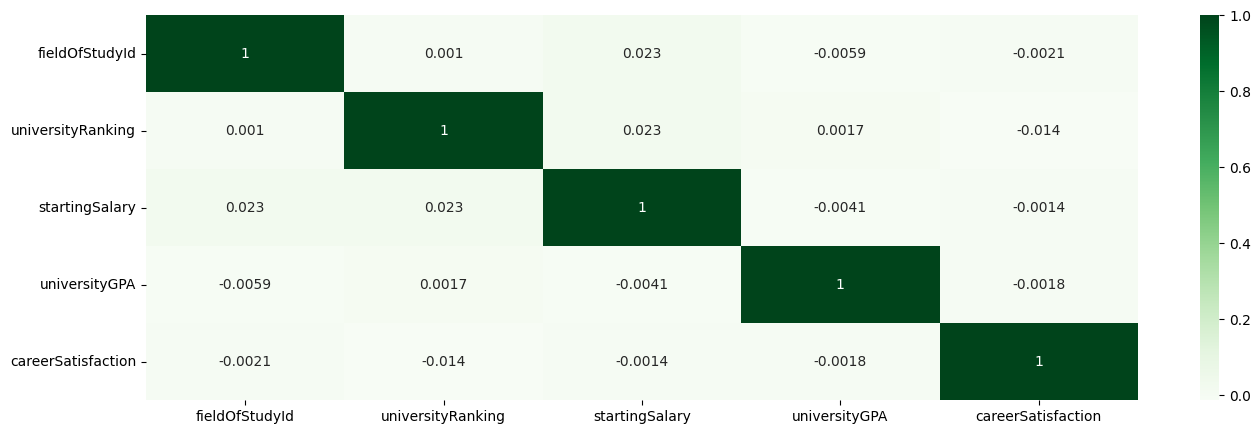

In [44]:

import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))  
sns.heatmap(corre_df, 
            xticklabels=corre_df.columns.values,
            yticklabels=corre_df.columns.values,  cmap="Greens", annot=True)


In [45]:


# Selecting relevant features
selected_features = ["fieldOfStudyId",  "startingSalary"]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_salary_vec = assembler.transform(df_all_merge.select(selected_features))

In [46]:
train_data, test_data = df_salary_vec.randomSplit([0.7, 0.3], seed=42)

In [48]:

lr = LinearRegression(featuresCol='features', labelCol='startingSalary')
model = lr.fit(train_data)

25/04/11 15:09:34 WARN Instrumentation: [729cbfc4] regParam is zero, which might cause numerical instability and overfitting.


In [54]:
predictions = model.transform(test_data)
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol='startingSalary', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

Root Mean Squared Error (RMSE) on test data: 3.713898834512442e-12


In [51]:


evaluator = RegressionEvaluator(labelCol="startingSalary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

evaluator_r2 = RegressionEvaluator(labelCol="startingSalary", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on test data: {:.3f}".format(r2))

Root Mean Squared Error (RMSE) on test data: 0.000
R-squared (R2) on test data: 1.000


In [24]:
hasher = FeatureHasher(inputCols=[
 'currentJobLevel',
 'universityRanking',
 'fieldOfStudyId',
 'universityGPA'


 ],
                       outputCol="features")

featurized = hasher.transform(df_all)
featurized.show(truncate=False)

IllegalArgumentException: universityRanking do(es) not exist. Available: studentId, achievementId, universityId, universityGPA, fieldOfStudyId, studentIdJob, startingSalary, careerSatisfaction, currentJobLevel

In [ ]:
final_data = featurized.select("features", "startingSalary")

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="startingSalary", predictionCol="predictionSalary")
lr_model = lr.fit(train_data)

In [ ]:
predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="startingSalary", predictionCol="predictionSalary", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

evaluator_r2 = RegressionEvaluator(labelCol="startingSalary", predictionCol="predictionSalary", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on test data: {:.3f}".format(r2))

Root Mean Squared Error (RMSE) on test data: 14886.621
R-squared (R2) on test data: -0.008


In [ ]:
lr_model.coefficients

SparseVector(262144, {31798: 452.4081, 62658: 1.1612, 94014: 204.3187, 104129: -33.4097, 182846: -241.156, 193847: 800.0815, 234364: -288.767})

25/04/10 00:19:09 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 974375 ms exceeds timeout 120000 ms
25/04/10 00:19:09 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/10 00:19:11 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
predictions.show()

+--------------------+--------------+------------------+
|            features|startingSalary|  predictionSalary|
+--------------------+--------------+------------------+
|(262144,[31798,62...|         65700|50023.331383257006|
|(262144,[31798,62...|         65400| 51057.69851886853|
|(262144,[31798,62...|         25000|50048.878840225974|
|(262144,[31798,62...|         45900|  50650.4889244936|
|(262144,[31798,62...|         62100|49893.332576650406|
|(262144,[31798,62...|         50300|51125.050905423064|
|(262144,[31798,62...|         69700| 49930.49251405981|
|(262144,[31798,62...|         71700| 51157.83237108814|
|(262144,[31798,62...|         32800| 50397.45879954466|
|(262144,[31798,62...|         45500| 50639.83214599167|
|(262144,[31798,62...|         49200|50202.430102471604|
|(262144,[31798,62...|         47500|51266.723166796415|
|(262144,[31798,62...|         43000| 51040.60729296602|
|(262144,[31798,62...|         53100| 51115.82189539703|
|(262144,[31798,62...|         

In [ ]:

lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[featurized, lr])

In [ ]:
   # Fit the pipeline to training documents.
model = pipeline.fit(df_student_achievement)

TypeError: Cannot recognize a pipeline stage of type <class 'pyspark.sql.dataframe.DataFrame'>.